**References:**

1. https://keras.io/api/applications/
2. https://keras.io/guides/transfer_learning/

In [ ]:
!nvidia-smi

Tue Aug 17 13:19:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

P100

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/MyDrive/SVNCKH'
! ls

/content/gdrive/MyDrive/SVNCKH
Database		     train_accuracy_01.png  valid_loss_01.png
Feature_extraction_01.ipynb  train_loss_01.png
Feature_extraction_02.ipynb  valid_accuracy_01.png


In [ ]:
# import the basic libraries
import numpy as np
import tensorflow as tf 
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Activation, Flatten, Reshape, ReLU
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras.layers import GlobalAveragePooling2D, Concatenate, Lambda
from keras.optimizers import Adam, RMSprop, Nadam, SGD, Adagrad
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from glob import glob

**DenseNet121**

SGD

In [ ]:
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/gdrive/MyDrive/SVNCKH/Database/train'
valid_path = '/content/gdrive/MyDrive/SVNCKH/Database/valid'
test_path = '/content/gdrive/MyDrive/SVNCKH/Database/test'

In [ ]:
# add preprocessing layer to the front of DenseNet
densenet_sgd = DenseNet121(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
# don't train existing weights
for layer in densenet_sgd.layers:
  layer.trainable = False

In [ ]:
# useful for getting number of classes
folders = glob('/content/gdrive/MyDrive/SVNCKH/Database/train/*')

In [ ]:
# our layers - you can add more if you want
x = Flatten()(densenet_sgd.output)

In [ ]:
#x = Dense(3, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [ ]:
# create a model object
model = Model(inputs=densenet_sgd.input, outputs=prediction)

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='sgd',
  metrics=['accuracy']
)

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 64 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 1260 images belonging to 6 classes.
Found 270 images belonging to 6 classes.
Found 270 images belonging to 6 classes.


In [ ]:
# fit the model
densenet_sgd = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=30,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

Epoch 1/30
20/20 [==============================] - 797s 36s/step - loss: 8.4929 - accuracy: 0.4316 - val_loss: 0.7329 - val_accuracy: 0.8519
Epoch 2/30
20/20 [==============================] - 20s 1s/step - loss: 0.6480 - accuracy: 0.9329 - val_loss: 0.1540 - val_accuracy: 0.9481
Epoch 3/30
20/20 [==============================] - 20s 1s/step - loss: 0.0311 - accuracy: 0.9890 - val_loss: 0.1204 - val_accuracy: 0.9667
Epoch 4/30
20/20 [==============================] - 20s 999ms/step - loss: 0.0306 - accuracy: 0.9907 - val_loss: 0.1281 - val_accuracy: 0.9519
Epoch 5/30
20/20 [==============================] - 20s 998ms/step - loss: 0.0167 - accuracy: 0.9946 - val_loss: 0.0849 - val_accuracy: 0.9704
Epoch 6/30
20/20 [==============================] - 20s 1s/step - loss: 0.0122 - accuracy: 0.9943 - val_loss: 0.0618 - val_accuracy: 0.9778
Epoch 7/30
20/20 [==============================] - 20s 996ms/step - loss: 0.0108 - accuracy: 0.9970 - val_loss: 0.0581 - val_accuracy: 0.9741
Epoch 8/3

In [ ]:
# testing
score = model.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 0.0667
Test accuracy: 0.9778


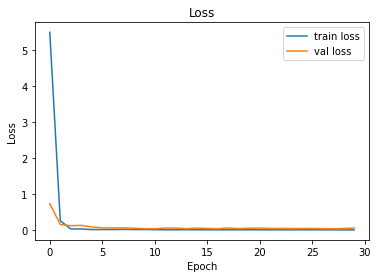

In [ ]:
# loss
plt.plot(densenet_sgd.history['loss'], label='train loss')
plt.plot(densenet_sgd.history['val_loss'], label='val loss')
plt.title(label = 'Loss', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

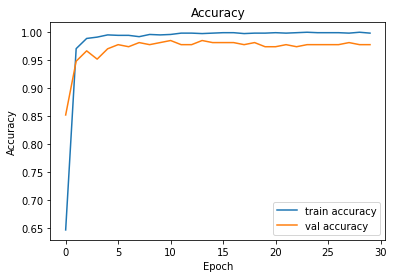

In [ ]:
# accuracy
plt.plot(densenet_sgd.history['accuracy'], label='train accuracy')
plt.plot(densenet_sgd.history['val_accuracy'], label='val accuracy')
plt.title(label = 'Accuracy', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

AdaGrad

In [ ]:
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/gdrive/MyDrive/SVNCKH/Database/train'
valid_path = '/content/gdrive/MyDrive/SVNCKH/Database/valid'
test_path = '/content/gdrive/MyDrive/SVNCKH/Database/test'

In [ ]:
# add preprocessing layer to the front of DenseNet
densenet_adagrad = DenseNet121(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
# don't train existing weights
for layer in densenet_adagrad.layers:
  layer.trainable = False

In [ ]:
# useful for getting number of classes
folders = glob('/content/gdrive/MyDrive/SVNCKH/Database/train/*')

In [ ]:
# our layers - you can add more if you want
x = Flatten()(densenet_adagrad.output)

In [ ]:
#x = Dense(3, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [ ]:
# create a model object
model = Model(inputs=densenet_adagrad.input, outputs=prediction)

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adagrad',
  metrics=['accuracy']
)

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 64 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 1260 images belonging to 6 classes.
Found 270 images belonging to 6 classes.
Found 270 images belonging to 6 classes.


In [ ]:
# fit the model
densenet_adagrad = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=30,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

Epoch 1/30
20/20 [==============================] - 55s 2s/step - loss: 1.2639 - accuracy: 0.5567 - val_loss: 0.3237 - val_accuracy: 0.9444
Epoch 2/30
20/20 [==============================] - 20s 992ms/step - loss: 0.2136 - accuracy: 0.9797 - val_loss: 0.2284 - val_accuracy: 0.9667
Epoch 3/30
20/20 [==============================] - 20s 1s/step - loss: 0.1261 - accuracy: 0.9801 - val_loss: 0.1942 - val_accuracy: 0.9667
Epoch 4/30
20/20 [==============================] - 20s 1s/step - loss: 0.0946 - accuracy: 0.9890 - val_loss: 0.1555 - val_accuracy: 0.9852
Epoch 5/30
20/20 [==============================] - 20s 991ms/step - loss: 0.0717 - accuracy: 0.9923 - val_loss: 0.1466 - val_accuracy: 0.9815
Epoch 6/30
20/20 [==============================] - 20s 998ms/step - loss: 0.0716 - accuracy: 0.9908 - val_loss: 0.1317 - val_accuracy: 0.9815
Epoch 7/30
20/20 [==============================] - 20s 989ms/step - loss: 0.0541 - accuracy: 0.9976 - val_loss: 0.1248 - val_accuracy: 0.9815
Epoch 8/

In [ ]:
# testing
score = model.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 0.0580
Test accuracy: 0.9852


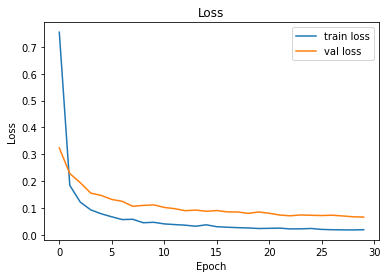

In [ ]:
# loss
plt.plot(densenet_adagrad.history['loss'], label='train loss')
plt.plot(densenet_adagrad.history['val_loss'], label='val loss')
plt.title(label = 'Loss', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

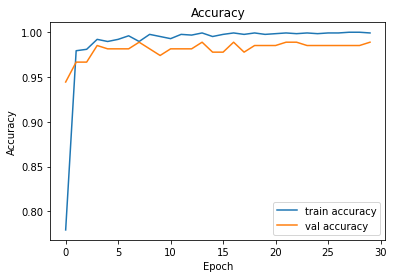

In [ ]:
# accuracy
plt.plot(densenet_adagrad.history['accuracy'], label='train accuracy')
plt.plot(densenet_adagrad.history['val_accuracy'], label='val accuracy')
plt.title(label = 'Accuracy', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

RMSprop

In [ ]:
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/gdrive/MyDrive/SVNCKH/Database/train'
valid_path = '/content/gdrive/MyDrive/SVNCKH/Database/valid'
test_path = '/content/gdrive/MyDrive/SVNCKH/Database/test'

In [ ]:
# add preprocessing layer to the front of DenseNet
densenet_RMSprop = DenseNet121(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
# don't train existing weights
for layer in densenet_RMSprop.layers:
  layer.trainable = False

In [ ]:
# useful for getting number of classes
folders = glob('/content/gdrive/MyDrive/SVNCKH/Database/train/*')

In [ ]:
# our layers - you can add more if you want
x = Flatten()(densenet_RMSprop.output)

In [ ]:
#x = Dense(3, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [ ]:
# create a model object
model = Model(inputs=densenet_RMSprop.input, outputs=prediction)

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='RMSprop',
  metrics=['accuracy']
)

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 64 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 1260 images belonging to 6 classes.
Found 270 images belonging to 6 classes.
Found 270 images belonging to 6 classes.


In [ ]:
# fit the model
densenet_RMSprop = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=30,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

Epoch 1/30
20/20 [==============================] - 56s 2s/step - loss: 3.3087 - accuracy: 0.5802 - val_loss: 0.2610 - val_accuracy: 0.8778
Epoch 2/30
20/20 [==============================] - 20s 1s/step - loss: 0.1297 - accuracy: 0.9553 - val_loss: 1.2526 - val_accuracy: 0.7000
Epoch 3/30
20/20 [==============================] - 21s 1s/step - loss: 0.5948 - accuracy: 0.9197 - val_loss: 0.7977 - val_accuracy: 0.8185
Epoch 4/30
20/20 [==============================] - 21s 1s/step - loss: 0.1207 - accuracy: 0.9638 - val_loss: 0.0129 - val_accuracy: 0.9963
Epoch 5/30
20/20 [==============================] - 20s 1s/step - loss: 0.1188 - accuracy: 0.9693 - val_loss: 0.0481 - val_accuracy: 0.9815
Epoch 6/30
20/20 [==============================] - 21s 1s/step - loss: 0.0891 - accuracy: 0.9762 - val_loss: 0.0171 - val_accuracy: 0.9926
Epoch 7/30
20/20 [==============================] - 20s 1s/step - loss: 0.1733 - accuracy: 0.9640 - val_loss: 0.2100 - val_accuracy: 0.9407
Epoch 8/30
20/20 [==

In [ ]:
# testing
score = model.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 0.0301
Test accuracy: 0.9926


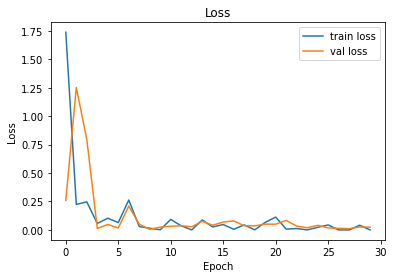

In [ ]:
# loss
plt.plot(densenet_RMSprop.history['loss'], label='train loss')
plt.plot(densenet_RMSprop.history['val_loss'], label='val loss')
plt.title(label = 'Loss', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

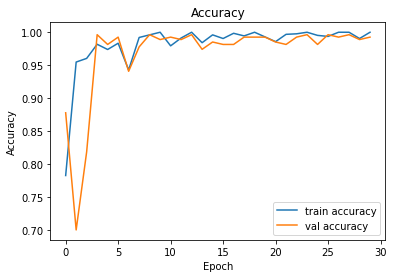

In [ ]:
# accuracy
plt.plot(densenet_RMSprop.history['accuracy'], label='train accuracy')
plt.plot(densenet_RMSprop.history['val_accuracy'], label='val accuracy')
plt.title(label = 'Accuracy', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Nadam

In [ ]:
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/gdrive/MyDrive/SVNCKH/Database/train'
valid_path = '/content/gdrive/MyDrive/SVNCKH/Database/valid'
test_path = '/content/gdrive/MyDrive/SVNCKH/Database/test'

In [ ]:
# add preprocessing layer to the front of DenseNet
densenet_nadam = DenseNet121(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
# don't train existing weights
for layer in densenet_nadam.layers:
  layer.trainable = False

In [ ]:
# useful for getting number of classes
folders = glob('/content/gdrive/MyDrive/SVNCKH/Database/train/*')

In [ ]:
# our layers - you can add more if you want
x = Flatten()(densenet_nadam.output)

In [ ]:
#x = Dense(3, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [ ]:
# create a model object
model = Model(inputs=densenet_nadam.input, outputs=prediction)

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='nadam',
  metrics=['accuracy']
)

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 64 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 1260 images belonging to 6 classes.
Found 270 images belonging to 6 classes.
Found 270 images belonging to 6 classes.


In [ ]:
# fit the model
densenet_nadam = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=30,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

Epoch 1/30
20/20 [==============================] - 57s 2s/step - loss: 1.3279 - accuracy: 0.6343 - val_loss: 0.0826 - val_accuracy: 0.9778
Epoch 2/30
20/20 [==============================] - 20s 1s/step - loss: 0.0396 - accuracy: 0.9893 - val_loss: 0.0832 - val_accuracy: 0.9704
Epoch 3/30
20/20 [==============================] - 20s 979ms/step - loss: 0.0136 - accuracy: 0.9995 - val_loss: 0.0560 - val_accuracy: 0.9778
Epoch 4/30
20/20 [==============================] - 20s 991ms/step - loss: 0.0074 - accuracy: 0.9994 - val_loss: 0.0397 - val_accuracy: 0.9852
Epoch 5/30
20/20 [==============================] - 20s 998ms/step - loss: 0.0079 - accuracy: 0.9988 - val_loss: 0.0554 - val_accuracy: 0.9778
Epoch 6/30
20/20 [==============================] - 20s 1s/step - loss: 0.0085 - accuracy: 0.9991 - val_loss: 0.0568 - val_accuracy: 0.9741
Epoch 7/30
20/20 [==============================] - 20s 999ms/step - loss: 0.0125 - accuracy: 0.9924 - val_loss: 0.0386 - val_accuracy: 0.9889
Epoch 8/

In [ ]:
# testing
score = model.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 0.0222
Test accuracy: 0.9889


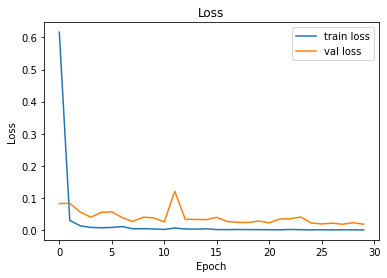

In [ ]:
# loss
plt.plot(densenet_nadam.history['loss'], label='train loss')
plt.plot(densenet_nadam.history['val_loss'], label='val loss')
plt.title(label = 'Loss', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

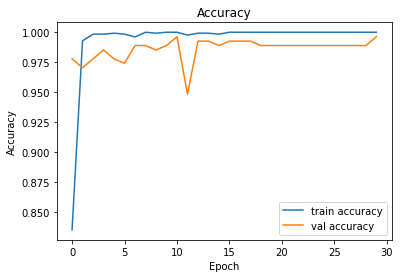

In [ ]:
# accuracy
plt.plot(densenet_nadam.history['accuracy'], label='train accuracy')
plt.plot(densenet_nadam.history['val_accuracy'], label='val accuracy')
plt.title(label = 'Accuracy', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Adam

In [ ]:
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/gdrive/MyDrive/SVNCKH/Database/train'
valid_path = '/content/gdrive/MyDrive/SVNCKH/Database/valid'
test_path = '/content/gdrive/MyDrive/SVNCKH/Database/test'

In [ ]:
# add preprocessing layer to the front of DenseNet
densenet_adam = DenseNet121(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
# don't train existing weights
for layer in densenet_adam.layers:
  layer.trainable = False

In [ ]:
# useful for getting number of classes
folders = glob('/content/gdrive/MyDrive/SVNCKH/Database/train/*')

In [ ]:
# our layers - you can add more if you want
x = Flatten()(densenet_adam.output)

In [ ]:
#x = Dense(3, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [ ]:
# create a model object
model = Model(inputs=densenet_adam.input, outputs=prediction)

In [ ]:
# view the structure of the model
#model.summary()

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 64 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 1260 images belonging to 6 classes.
Found 270 images belonging to 6 classes.
Found 270 images belonging to 6 classes.


In [ ]:
# fit the model
densenet_adam = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=30,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

Epoch 1/30
20/20 [==============================] - 54s 1s/step - loss: 1.3122 - accuracy: 0.6490 - val_loss: 0.0988 - val_accuracy: 0.9556
Epoch 2/30
20/20 [==============================] - 19s 962ms/step - loss: 0.1073 - accuracy: 0.9719 - val_loss: 0.0565 - val_accuracy: 0.9815
Epoch 3/30
20/20 [==============================] - 19s 959ms/step - loss: 0.0123 - accuracy: 0.9956 - val_loss: 0.0329 - val_accuracy: 0.9852
Epoch 4/30
20/20 [==============================] - 20s 969ms/step - loss: 0.0059 - accuracy: 0.9973 - val_loss: 0.0315 - val_accuracy: 0.9889
Epoch 5/30
20/20 [==============================] - 20s 973ms/step - loss: 0.0056 - accuracy: 0.9971 - val_loss: 0.0160 - val_accuracy: 0.9926
Epoch 6/30
20/20 [==============================] - 19s 963ms/step - loss: 0.0104 - accuracy: 0.9949 - val_loss: 0.0139 - val_accuracy: 1.0000
Epoch 7/30
20/20 [==============================] - 19s 962ms/step - loss: 0.0037 - accuracy: 0.9988 - val_loss: 0.0487 - val_accuracy: 0.9815
Ep

In [ ]:
# testing
score = model.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 0.0379
Test accuracy: 0.9889


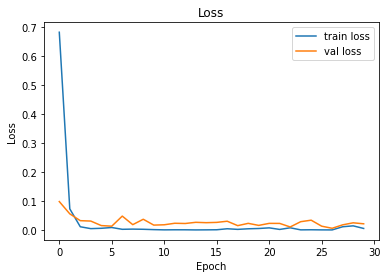

In [ ]:
# loss
plt.plot(densenet_adam.history['loss'], label='train loss')
plt.plot(densenet_adam.history['val_loss'], label='val loss')
plt.title(label = 'Loss', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

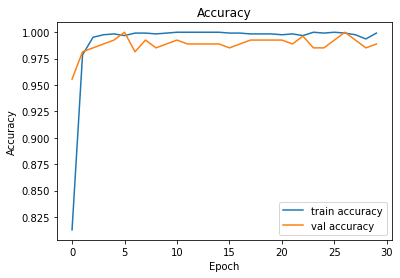

In [ ]:
# accuracy
plt.plot(densenet_adam.history['accuracy'], label='train accuracy')
plt.plot(densenet_adam.history['val_accuracy'], label='val accuracy')
plt.title(label = 'Accuracy', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Adadelta**

In [ ]:
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/gdrive/MyDrive/SVNCKH/Database/train'
valid_path = '/content/gdrive/MyDrive/SVNCKH/Database/valid'
test_path = '/content/gdrive/MyDrive/SVNCKH/Database/test'

In [ ]:
# add preprocessing layer to the front of DenseNet
densenet_adadelta = DenseNet121(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
# don't train existing weights
for layer in densenet_adadelta.layers:
  layer.trainable = False

In [ ]:
# useful for getting number of classes
folders = glob('/content/gdrive/MyDrive/SVNCKH/Database/train/*')

In [ ]:
# our layers - you can add more if you want
x = Flatten()(densenet_adadelta.output)

In [ ]:
#x = Dense(3, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [ ]:
# create a model object
model = Model(inputs=densenet_adadelta.input, outputs=prediction)

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adadelta',
  metrics=['accuracy']
)

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 64 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 1260 images belonging to 6 classes.
Found 270 images belonging to 6 classes.
Found 270 images belonging to 6 classes.


In [ ]:
# fit the model
densenet_adadelta = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=30,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

Epoch 1/30
20/20 [==============================] - 54s 2s/step - loss: 1.8545 - accuracy: 0.2464 - val_loss: 1.7988 - val_accuracy: 0.2333
Epoch 2/30
20/20 [==============================] - 20s 984ms/step - loss: 1.7766 - accuracy: 0.2483 - val_loss: 1.7249 - val_accuracy: 0.2852
Epoch 3/30
20/20 [==============================] - 20s 973ms/step - loss: 1.7027 - accuracy: 0.3058 - val_loss: 1.6607 - val_accuracy: 0.3185
Epoch 4/30
20/20 [==============================] - 20s 975ms/step - loss: 1.5960 - accuracy: 0.3619 - val_loss: 1.6029 - val_accuracy: 0.3556
Epoch 5/30
20/20 [==============================] - 20s 988ms/step - loss: 1.5622 - accuracy: 0.3674 - val_loss: 1.5491 - val_accuracy: 0.3704
Epoch 6/30
20/20 [==============================] - 20s 976ms/step - loss: 1.5022 - accuracy: 0.4129 - val_loss: 1.4966 - val_accuracy: 0.3926
Epoch 7/30
20/20 [==============================] - 20s 988ms/step - loss: 1.4763 - accuracy: 0.4146 - val_loss: 1.4509 - val_accuracy: 0.4407
Ep

In [ ]:
# testing
score = model.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 0.8258
Test accuracy: 0.8296


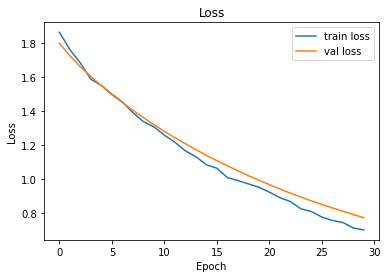

In [ ]:
# loss
plt.plot(densenet_adadelta.history['loss'], label='train loss')
plt.plot(densenet_adadelta.history['val_loss'], label='val loss')
plt.title(label = 'Loss', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

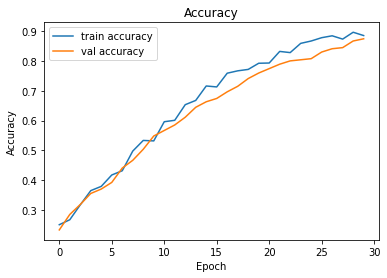

In [ ]:
# accuracy
plt.plot(densenet_adadelta.history['accuracy'], label='train accuracy')
plt.plot(densenet_adadelta.history['val_accuracy'], label='val accuracy')
plt.title(label = 'Accuracy', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Adamax**

In [ ]:
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/gdrive/MyDrive/SVNCKH/Database/train'
valid_path = '/content/gdrive/MyDrive/SVNCKH/Database/valid'
test_path = '/content/gdrive/MyDrive/SVNCKH/Database/test'

In [ ]:
# add preprocessing layer to the front of DenseNet
densenet_adamax = DenseNet121(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
# don't train existing weights
for layer in densenet_adamax.layers:
  layer.trainable = False

In [ ]:
# useful for getting number of classes
folders = glob('/content/gdrive/MyDrive/SVNCKH/Database/train/*')

In [ ]:
# our layers - you can add more if you want
x = Flatten()(densenet_adamax.output)

In [ ]:
#x = Dense(3, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [ ]:
# create a model object
model = Model(inputs=densenet_adamax.input, outputs=prediction)

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adamax',
  metrics=['accuracy']
)

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 64 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 1260 images belonging to 6 classes.
Found 270 images belonging to 6 classes.
Found 270 images belonging to 6 classes.


In [ ]:
# fit the model
densenet_adamax = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=30,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

Epoch 1/30
20/20 [==============================] - 56s 2s/step - loss: 1.5526 - accuracy: 0.5767 - val_loss: 0.0976 - val_accuracy: 0.9630
Epoch 2/30
20/20 [==============================] - 20s 997ms/step - loss: 0.0505 - accuracy: 0.9866 - val_loss: 0.0437 - val_accuracy: 0.9889
Epoch 3/30
20/20 [==============================] - 20s 1s/step - loss: 0.0219 - accuracy: 0.9939 - val_loss: 0.0508 - val_accuracy: 0.9852
Epoch 4/30
20/20 [==============================] - 20s 997ms/step - loss: 0.0189 - accuracy: 0.9944 - val_loss: 0.0378 - val_accuracy: 0.9889
Epoch 5/30
20/20 [==============================] - 20s 1000ms/step - loss: 0.0162 - accuracy: 0.9959 - val_loss: 0.0478 - val_accuracy: 0.9852
Epoch 6/30
20/20 [==============================] - 20s 1s/step - loss: 0.0134 - accuracy: 0.9983 - val_loss: 0.0400 - val_accuracy: 0.9889
Epoch 7/30
20/20 [==============================] - 20s 996ms/step - loss: 0.0140 - accuracy: 0.9966 - val_loss: 0.0389 - val_accuracy: 0.9852
Epoch 8

In [ ]:
# testing
score = model.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 0.0332
Test accuracy: 0.9889


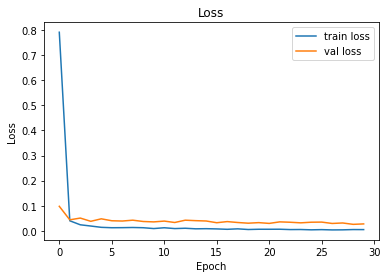

In [ ]:
# loss
plt.plot(densenet_adamax.history['loss'], label='train loss')
plt.plot(densenet_adamax.history['val_loss'], label='val loss')
plt.title(label = 'Loss', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

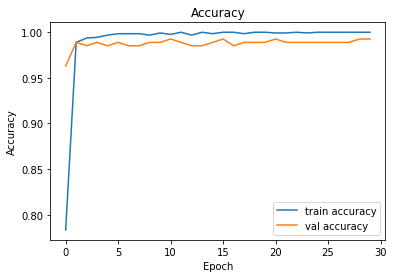

In [ ]:
# accuracy
plt.plot(densenet_adamax.history['accuracy'], label='train accuracy')
plt.plot(densenet_adamax.history['val_accuracy'], label='val accuracy')
plt.title(label = 'Accuracy', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Ftrl

In [ ]:
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/gdrive/MyDrive/SVNCKH/Database/train'
valid_path = '/content/gdrive/MyDrive/SVNCKH/Database/valid'
test_path = '/content/gdrive/MyDrive/SVNCKH/Database/test'

In [ ]:
# add preprocessing layer to the front of DenseNet
densenet_ftrl = DenseNet121(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
# don't train existing weights
for layer in densenet_ftrl.layers:
  layer.trainable = False

In [ ]:
# useful for getting number of classes
folders = glob('/content/gdrive/MyDrive/SVNCKH/Database/train/*')

In [ ]:
# our layers - you can add more if you want
x = Flatten()(densenet_ftrl.output)

In [ ]:
#x = Dense(3, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [ ]:
# create a model object
model = Model(inputs=densenet_ftrl.input, outputs=prediction)

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='ftrl',
  metrics=['accuracy']
)

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 64 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 1260 images belonging to 6 classes.
Found 270 images belonging to 6 classes.
Found 270 images belonging to 6 classes.


In [ ]:
# fit the model
densenet_ftrl = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=30,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

Epoch 1/30
20/20 [==============================] - 55s 2s/step - loss: 1.1616 - accuracy: 0.6302 - val_loss: 0.3360 - val_accuracy: 0.9148
Epoch 2/30
20/20 [==============================] - 20s 983ms/step - loss: 0.2011 - accuracy: 0.9820 - val_loss: 0.2202 - val_accuracy: 0.9667
Epoch 3/30
20/20 [==============================] - 20s 980ms/step - loss: 0.1248 - accuracy: 0.9880 - val_loss: 0.1634 - val_accuracy: 0.9852
Epoch 4/30
20/20 [==============================] - 21s 1s/step - loss: 0.0948 - accuracy: 0.9949 - val_loss: 0.1479 - val_accuracy: 0.9852
Epoch 5/30
20/20 [==============================] - 20s 1000ms/step - loss: 0.0696 - accuracy: 0.9954 - val_loss: 0.1375 - val_accuracy: 0.9778
Epoch 6/30
20/20 [==============================] - 20s 998ms/step - loss: 0.0665 - accuracy: 0.9945 - val_loss: 0.1192 - val_accuracy: 0.9852
Epoch 7/30
20/20 [==============================] - 20s 992ms/step - loss: 0.0588 - accuracy: 0.9929 - val_loss: 0.1142 - val_accuracy: 0.9778
Epoc

In [ ]:
# testing
score = model.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 0.0505
Test accuracy: 0.9852


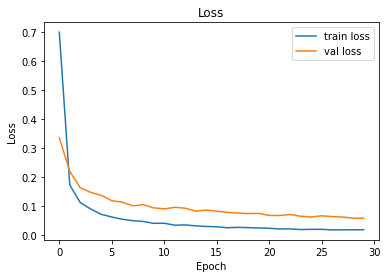

In [ ]:
# loss
plt.plot(densenet_ftrl.history['loss'], label='train loss')
plt.plot(densenet_ftrl.history['val_loss'], label='val loss')
plt.title(label = 'Loss', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

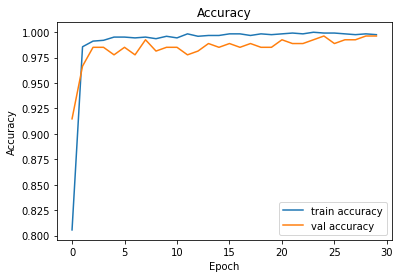

In [ ]:
# accuracy
plt.plot(densenet_ftrl.history['accuracy'], label='train accuracy')
plt.plot(densenet_ftrl.history['val_accuracy'], label='val accuracy')
plt.title(label = 'Accuracy', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**The accuracy comparison charts:**

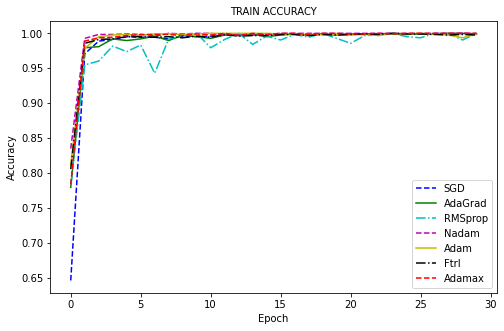

In [ ]:
# train accuracy
fig, axes = plt.subplots(1, 1, figsize=(8, 5))
plt.plot(densenet_sgd.history['accuracy'], '--b', label='SGD')
plt.plot(densenet_adagrad.history['accuracy'], '-g', label='AdaGrad')
plt.plot(densenet_RMSprop.history['accuracy'], '-.c', label='RMSprop')
plt.plot(densenet_nadam.history['accuracy'], '--m', label='Nadam')
plt.plot(densenet_adam.history['accuracy'], '-y', label='Adam')
#plt.plot(densenet_adadelta.history['accuracy'], '-.k', label='Adadelta')
plt.plot(densenet_ftrl.history['accuracy'], '-.k', label='Ftrl')
plt.plot(densenet_adamax.history['accuracy'], '--r', label='Adamax')
plt.title(label = 'TRAIN ACCURACY', fontsize = 10, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
fig.savefig('train_accuracy_02')

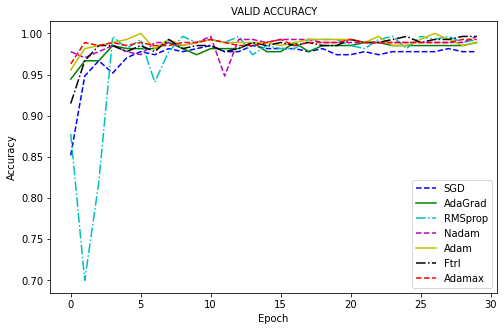

In [ ]:
# valid accuracy
fig, axes = plt.subplots(1, 1, figsize=(8, 5))
plt.plot(densenet_sgd.history['val_accuracy'], '--b', label='SGD')
plt.plot(densenet_adagrad.history['val_accuracy'], '-g', label='AdaGrad')
plt.plot(densenet_RMSprop.history['val_accuracy'], '-.c', label='RMSprop')
plt.plot(densenet_nadam.history['val_accuracy'], '--m', label='Nadam')
plt.plot(densenet_adam.history['val_accuracy'], '-y', label='Adam')
#plt.plot(densenet_adadelta.history['val_accuracy'], '-.k', label='Adadelta')
plt.plot(densenet_ftrl.history['val_accuracy'], '-.k', label='Ftrl')
plt.plot(densenet_adamax.history['val_accuracy'], '--r', label='Adamax')
plt.title(label = 'VALID ACCURACY', fontsize = 10, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
fig.savefig('valid_accuracy_02')

**The loss comparison charts:**

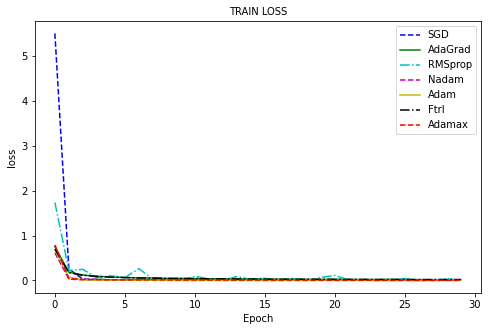

In [ ]:
# train loss
fig, axes = plt.subplots(1, 1, figsize=(8, 5))
plt.plot(densenet_sgd.history['loss'], '--b', label='SGD')
plt.plot(densenet_adagrad.history['loss'], '-g', label='AdaGrad')
plt.plot(densenet_RMSprop.history['loss'], '-.c', label='RMSprop')
plt.plot(densenet_nadam.history['loss'], '--m', label='Nadam')
plt.plot(densenet_adam.history['loss'], '-y', label='Adam')
#plt.plot(densenet_adadelta.history['loss'], '-.k', label='Adadelta')
plt.plot(densenet_ftrl.history['loss'], '-.k', label='Ftrl')
plt.plot(densenet_adamax.history['loss'], '--r', label='Adamax')
plt.title(label = 'TRAIN LOSS', fontsize = 10, color = "black")
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()
fig.savefig('train_loss_02')

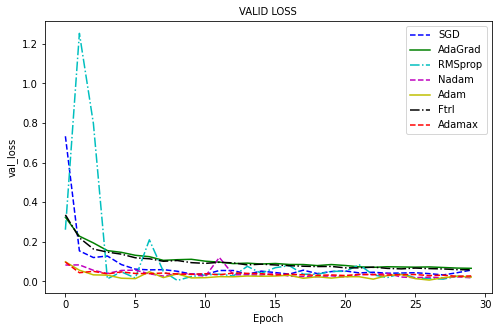

In [ ]:
# valid loss
fig, axes = plt.subplots(1, 1, figsize=(8, 5))
plt.plot(densenet_sgd.history['val_loss'], '--b', label='SGD')
plt.plot(densenet_adagrad.history['val_loss'], '-g', label='AdaGrad')
plt.plot(densenet_RMSprop.history['val_loss'], '-.c', label='RMSprop')
plt.plot(densenet_nadam.history['val_loss'], '--m', label='Nadam')
plt.plot(densenet_adam.history['val_loss'], '-y', label='Adam')
#plt.plot(densenet_adadelta.history['val_loss'], '-.k', label='Adadelta')
plt.plot(densenet_ftrl.history['val_loss'], '-.k', label='Ftrl')
plt.plot(densenet_adamax.history['val_loss'], '--r', label='Adamax')
plt.title(label = 'VALID LOSS', fontsize = 10, color = "black")
plt.xlabel('Epoch')
plt.ylabel('val_loss')
plt.legend()
plt.show()
fig.savefig('valid_loss_02')